In [1]:
from pyspark.sql.types import StructType, StructField, DateType, IntegerType
from main.utils.spark_utils import init_spark
from pyspark.sql.functions import pandas_udf, PandasUDFType
from fbprophet import Prophet
from collections.abc import Callable

import matplotlib.pyplot as plt
import plotly
import mlflow
import mlflow.sklearn
import shutil
import pandas as pd


In [2]:
%matplotlib inline

In [3]:
spark = init_spark('forecasting')

In [4]:
# structure of the training data set
train_schema = StructType([
  StructField('date', DateType()),
  StructField('store', IntegerType()),
  StructField('item', IntegerType()),
  StructField('sales', IntegerType())
  ])

# read the training file into a DataFrame
train = spark.read.csv(
  '../src/main/resources/kaggle/train.csv',
  header=True,
  schema=train_schema
  )

train.show(5)

# make the DataFrame available as query temporary view
train.createOrReplaceTempView('train')

+----------+-----+----+-----+
|      date|store|item|sales|
+----------+-----+----+-----+
|2013-01-01|    1|   1|   13|
|2013-01-02|    1|   1|   11|
|2013-01-03|    1|   1|   14|
|2013-01-04|    1|   1|   13|
|2013-01-05|    1|   1|   10|
+----------+-----+----+-----+
only showing top 5 rows



   year     sales
0  2013   7941243
1  2014   9135482
2  2015   9536887
3  2016  10357160
4  2017  10733740


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2349: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  if isinstance(obj, collections.Iterator):


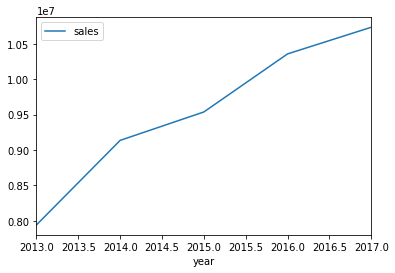

In [5]:
# Plot sales per year
sql_per_year = '''
 SELECT
   year(date) as year,
   sum(sales) as sales
 FROM train
 GROUP BY year(date)
 ORDER BY year
  '''
sql_per_year = spark.sql(sql_per_year).toPandas()
# drop any missing records
sql_per_year = sql_per_year.dropna()
print(sql_per_year.head())

sql_per_year.plot(x='year', y='sales')

        month   sales
0  2013-01-01  454904
1  2013-02-01  459417
2  2013-03-01  617382
3  2013-04-01  682274
4  2013-05-01  763242


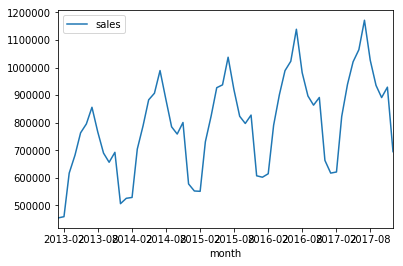

In [6]:
# Plot sales per month
sql_per_month = '''
 SELECT 
   TRUNC(date, 'MM') as month,
   SUM(sales) as sales
 FROM train
 GROUP BY TRUNC(date, 'MM')
 ORDER BY month
  '''
sql_per_month = spark.sql(sql_per_month).toPandas()
# drop any missing records
sql_per_month = sql_per_month.dropna()
print(sql_per_month.head())

sql_per_month.plot(x='month', y='sales')

   year  weekday         sales
0  2013        0  25788.442308
1  2013        1  17269.692308
2  2013        2  20015.811321
3  2013        3  20150.153846
4  2013        4  21503.192308


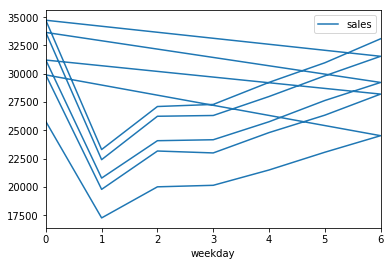

In [7]:
# Plot sales per day of week
sql_per_day_w = '''
    SELECT
      YEAR(date) as year,
      CAST(DATE_FORMAT(date, 'u') as Integer) % 7 as weekday,
      AVG(sales) as sales
    FROM (
      SELECT 
        date,
        SUM(sales) as sales
      FROM train
      GROUP BY date
     ) x
    GROUP BY year, CAST(DATE_FORMAT(date, 'u') as Integer) --, CONCAT(DATE_FORMAT(date, 'u'), '-', DATE_FORMAT(date, 'EEEE'))
    ORDER BY year, weekday
     '''

sql_per_day_w = spark.sql(sql_per_day_w).toPandas()
# drop any missing records
sql_per_day_w = sql_per_day_w.dropna()
print(sql_per_day_w.head())

sql_per_day_w.plot(x='weekday', y=['sales'])

           ds   y
0  2013-01-01  13
1  2013-01-02  11
2  2013-01-03  14
3  2013-01-04  13
4  2013-01-05  10


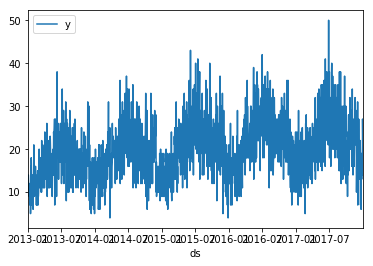

In [8]:
# query to aggregate data to date (ds) level
sql_statement = '''
  SELECT
    date as ds,
    sales as y
  FROM train
  WHERE store=1 AND item=1
  ORDER BY ds
  '''

# assemble DataSet in Pandas DataFrame
history_pd = spark.sql(sql_statement).toPandas()
# drop any missing records
history_pd = history_pd.dropna()
print(history_pd.head())

history_pd.plot(x='ds', y='y')

In [9]:
# Our first step is to assemble the historical DataSet on which we will train the model
# instantiate the model and set parameters
model = Prophet(
    interval_width=0.95,
    growth='linear',
    daily_seasonality=False,
    weekly_seasonality=True,
    yearly_seasonality=True,
    seasonality_mode='multiplicative'
)

# fit the model to historical data
model.fit(history_pd)

In [10]:
'''Now that we have a trained model, let's use it to build a 90-day forecast:'''
period_days=60

# define a dataset including both historical dates & 90-days beyond the last available date
future_pd = model.make_future_dataframe(
    periods=period_days,
    freq='d',
    include_history=True
)

In [11]:
# predict over the dataset
forecast_pd = model.predict(future_pd)

print(forecast_pd)

             ds      trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0    2013-01-01  15.604239    1.745665   19.069700    15.604239    15.604239   
1    2013-01-02  15.609935    1.715195   18.528644    15.609935    15.609935   
2    2013-01-03  15.615630    2.577522   19.470659    15.615630    15.615630   
3    2013-01-04  15.621326    3.837372   20.592287    15.621326    15.621326   
4    2013-01-05  15.627022    5.402671   23.070713    15.627022    15.627022   
5    2013-01-06  15.632717    5.545995   23.453979    15.632717    15.632717   
6    2013-01-07  15.638413   -1.108025   16.300628    15.638413    15.638413   
7    2013-01-08  15.644108    1.365170   18.559665    15.644108    15.644108   
8    2013-01-09  15.649804    1.946865   18.559326    15.649804    15.649804   
9    2013-01-10  15.655499    2.693874   18.769305    15.655499    15.655499   
10   2013-01-11  15.661195    3.620863   20.785085    15.661195    15.661195   
11   2013-01-12  15.666891    5.245780  

Figure(648x648)


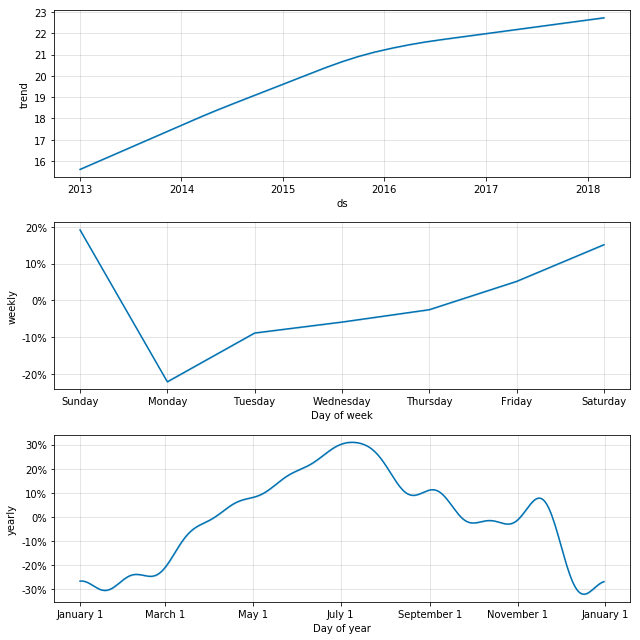

In [12]:
# How did our model perform? Here we can see the general and seasonal trends in our model presented as graphs:
trends_fig = model.plot_components(forecast_pd)
print(trends_fig)

Figure(720x432)


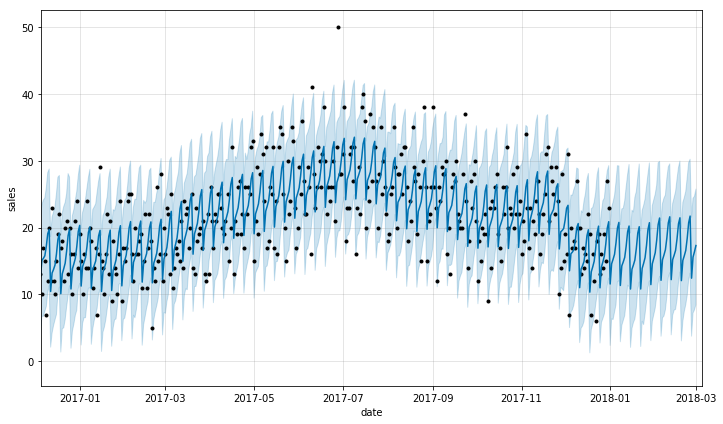

In [13]:
''' 
And here, we can see how our actual and predicted data line up as well as a forecast for the future,
though we will limit our graph to the last year of historical data just to keep it readable: 
'''
predict_fig = model.plot(forecast_pd, xlabel='date', ylabel='sales')

# adjust figure to display dates from last year + the 90 day forecast
x_lim = predict_fig.axes[0].get_xlim()
new_x_lim = (x_lim[1] - (180.0 + 365.0), x_lim[1] - 90.0)
predict_fig.axes[0].set_xlim(new_x_lim)

print(predict_fig)

plt.show()